# 2024-2 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 11기 김현진
- 과제 제출 기한 : 08.25

---
- 이름 : 김여원
- 기수 : 11기



In [1]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


코드의 빈칸을 채우는 것 외에 6개의 이론 + 학습 결과 확인 문제가 별도로 존재합니다. 꼼꼼히 확인하여 누락 없이 제출해주세요.

### 문제 1.

U-Net과 ResNet 아키텍쳐에서 동시에 등장하는 Skip Connection에 대해 설명해주세요.
Skip Connection의 간단한 정의와 각각의 모델에서 해당 기법이 왜 사용되는지를 중점으로 설명해주세요.

[풀이]


신경망 학습 시 발생할 수 있는 기울기 소실 문제를 해결하기 위한 방법 중 하나가 바로 'Skip Connection'이다. 인풋을 중간 레이어를 건너뛰고, 나중의 레이어에 직접 연결하여 정보 손실을 줄이고자 하는 기법이다.

U-Net에서는 저해상도의 피처맵을 디코더에 연결해 더 세밀한 정보를 복원하여 이미지 분할 성능을 향상시키기 위해 사용.

ResNet에서는 깊은 네트워크에서 기울기 소실 문제를 완화하고 잔차 학습을 통해 성능을 안정적으로 유지하기 위해 사용.



### 문제 2.

conv layer의 얕은 층과 깊은 층 간에는 feature map이 담고 있는 정보 특성에 trade-off가 존재합니다. 이에 대해 구체적으로 설명해주세요. U-Net은 이를 어떻게 해결하고 있는지 Skip Connection과 연관지어 설명해주세요.

[풀이]

conv layer의 얕은 층은 edge 등 이미지의 local하고 detail한 정보를, 깊은 층은 복잡한 패턴과 같이 이미지의 global하고 abstract한 정보를 담곤 하기 때문에 trade-off가 존재한다고 할 수 있다.

U-Net은 Skip Connection을 통해 얕은 층과 깊은 층의 feature map을 결합하는데, 이를 통해 공간 해상도와 추상적 정보의 trade-off 문제를 해결하여 더 정확한 예측이 가능하도록 하는 특징을 가진다.


## 라이브러리 가져오기 및 데이터 전처리

In [2]:
#필요한 라이브러리 가져오기
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets

데이터셋 설명: 총 30개의 세포 이미지와 각 픽셀의 레이블이 담긴 데이터셋입니다.
train, validation, test 데이터를 각각 24, 3, 3개로 나누어 학습 및 예측을 진행합니다.


U-Net이 아주 적은 학습 데이터셋에서도 Image segmentation을 잘 수행하고 있는지 직접 확인해보세요!

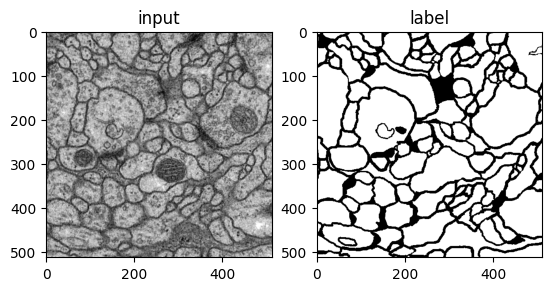

In [3]:
###해당 코드는 데이터셋 경로 수정 외에는 건드리지 말고 그대로 사용해주세요###

###데이터 전처리 코드###
## 라이브러리 불러오기
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 불러오기
dir_data = '/content/drive/MyDrive/[0825]CNN_YeowonKim/data'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

## train/test/val 폴더 생성
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

## 전체 이미지 30개를 섞어줌
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

## 선택된 train 이미지를 npy 파일로 저장
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

## 선택된 val 이미지를 npy 파일로 저장
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

## 선택된 test 이미지를 npy 파일로 저장
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

## 이미지 시각화
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

## 1. U-Net 모델 아키텍쳐 구현

제공된 reading material을 참고하여 U-Net 아키텍쳐를 구현해 보세요.
U-Net의 구조를 하나하나 뜯어서 파악하고, input과 output featuremap size를 직접 손으로 계산해 숫자를 넣어보세요.

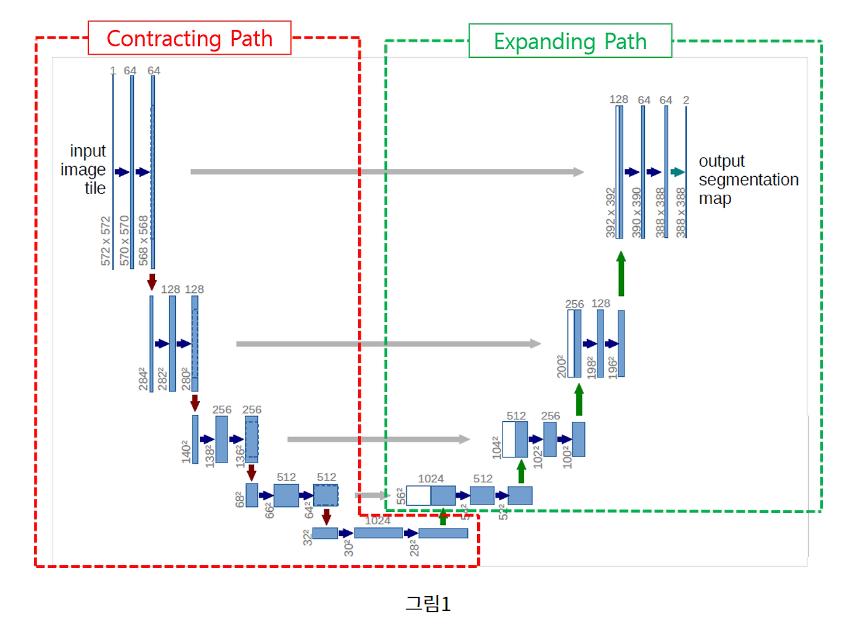

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)]
            layers += [nn.BatchNorm2d(out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(1, 64)
        self.enc1_2 = CBR2d(64, 64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(64, 128)
        self.enc2_2 = CBR2d(128, 128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(128, 256)
        self.enc3_2 = CBR2d(256, 256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(256,512)
        self.enc4_2 = CBR2d(512, 512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(512, 1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(1024,512)

        self.unpool4 = nn.ConvTranspose2d(512,512, kernel_size=2, stride=2, padding=0)

        self.dec4_2 = CBR2d(1024, 512)
        self.dec4_1 = CBR2d(512, 256)

        self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2, padding=0)

        self.dec3_2 = CBR2d(512, 256)
        self.dec3_1 = CBR2d(256, 128)

        self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2, padding=0)

        self.dec2_2 = CBR2d(256, 128)
        self.dec2_1 = CBR2d(128, 64)

        self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0)

        self.dec1_2 = CBR2d(128, 64)
        self.dec1_1 = CBR2d(64,64)

        self.fc = nn.Conv2d(64,1, kernel_size=1, stride=1, padding=0)

    # forward 함수 정의하기
    def forward(self, x):

      # 수축 경로(Contracting path)
      enc1_1 = self.enc1_1(x)
      enc1_2 = self.enc1_2(enc1_1)
      pool1 = self.pool1(enc1_2)

      enc2_1 = self.enc2_1(pool1)
      enc2_2 = self.enc2_2(enc2_1)
      pool2 = self.pool2(enc2_2)

      enc3_1 =self.enc3_1(pool2)
      enc3_2 = self.enc3_2(enc3_1)
      pool3 = self.pool3(enc3_2)

      enc4_1 = self.enc4_1(pool3)
      enc4_2 = self.enc4_2(enc4_1)
      pool4 = self.pool4(enc4_2)

      enc5_1 = self.enc5_1(pool4)


      # 확장 경로(Expansive path)
      dec5_1 = self.dec5_1(enc5_1)
      unpool4 = self.unpool4(dec5_1)

      dec4_2 = self.dec4_2(torch.cat((unpool4, enc4_2),dim=1))
      dec4_1= self.dec4_1(dec4_2)
      unpool3 = self.unpool3(dec4_1)

      dec3_2 = self.dec3_2(torch.cat((unpool3, enc3_2), dim=1))
      dec3_1 = self.dec3_1(dec3_2)
      unpool2 = self.unpool2(dec3_1)

      dec2_2 = self.dec2_2(torch.cat((unpool2, enc2_2), dim=1))
      dec2_1 = self.dec2_1(dec2_2)
      unpool1 = self.unpool1(dec2_1)

      dec1_2 = self.dec1_2(torch.cat((unpool1, enc1_2), dim=1))
      dec1_1 =self.dec1_1(dec1_2)

      x = self.fc(dec1_1)

      return x

## 2. Dataset & Transform
데이터가 흘러갈 네트워크를 앞서 선언해 주었습니다. 이제 데이터를 잘 처리해서 네트워크에 흘려보내주면 됩니다. 파이토치는 데이터를 불러오고 변환하는 과정을 Dataset class와 Transform class로 구현합니다. 해당 Dataset class 부분은 빈칸을 뚫어놓지 않았습니다. 코드를 찬찬히 살펴봐주세요.

In [5]:
######  코드 수정 금지  ######
# 데이터 로더 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

다음은 Transform인데, 이 부분은 여러분의 직관에 따라 원하는 전처리를 진행해주면 됩니다. 일반적으로 데이터가 numpy 형태라면 tensor로 바꿔주고, 이미지의 경우 Flip(방향 뒤집기)을 통해 data augumentation 효과를 주기도 합니다. 해당 코드는 데이터가 np 형태이므로 tensor로 바꿔주었고, 이미지이므로 언급한 두 변환에 더해 정규화도 취하고 있습니다.
\
\
외에 더하고 싶은 것을 추가해도 좋습니다. 자유롭게 수정해보세요 !

### 문제 3.

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다.

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 train 단계에서만 Augmention를 수행하게 됩니다. 그 이유에 대해서 설명해주세요.


[풀이]

Augmentaion은 모델 자체의 일반화 성능 향상을 위한 기법으로, train 단계에서만 사용되어야 적절하다. Validation과 Test 단계에서는 모델의 성능을 원본 데이터만을 통해 일관되게 평가해야 하기 때문이다.

In [6]:
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # numpy와 tensor의 배열 차원 순서가 다르다.
        # numpy : (행, 열, 채널)
        # tensor : (채널, 행, 열)
        # 따라서 위 순서에 맞춰 transpose

        label = label.transpose((2,0,1)).astype(np.float32)
        input = input.transpose((2,0,1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

######  수정 금지  ######
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data


######  TODO를 채우고 또 다른 기능을 자유롭게 추가해보세용  ######
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label':label, 'input':input}

        return data

class RandomRotation(object):
  def __call__(self,data):
    label,input = data['label'], data['input']

    k=np.random.randint(0,4) #90도 단위로 회전
    label = np.rot90(label,k)
    input = np.rot90(input,k)

    data = {'label':label, 'input':input}

    return data

In [7]:
######  코드 수정 금지  ######
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

## 문제 4.

U-Net 모델의 논문에서는 biomedical image segmentation에 최적화된 손실함수를 다음과 같이 따로 정의하고 있습니다.

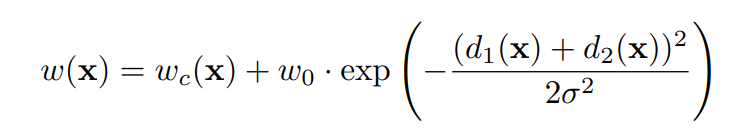

여기서 1) 가중치 w(x)의 의미는 무엇인지, 2) 가중치가 커지는 조건은 무엇인지, 3) 이러한 새로운 손실함수 정의의 목적(해당 task만의 특징에 기반하여)은 무엇인지 말로 풀어서 설명해주세요.

[풀이]

가중치 w(x)는 input이 output에 미치는 중요도를 조절하는 파라미터이다.

가중치가 커지는 조건은, 위 식에서 d1(x)+d2(x)가 작아야 한다. 즉, 경계 근처의 픽셀에 더 큰 가중치를 부여한다.

위와 같은 손실함수 정의의 목적은 모델이 경계 근처의 픽셀을 더 정확히 예측하도록 유도한다. 특히 세션에서 배운대로 경계가 모호한 의학 관련 이미지에서 그 역할이 두드러지며, 이를 통해 전체적인 segmentation 성능을 향상시키고자 한다.

## 3. 손실함수 정의

U-Net 논문을 통해 우리는 이들이 biomedical image segmentation을 위해 세포의 border pixel에 가중치를 두도록 하는 독특한 손실함수를 새로 정의하고 있음을 알 수 있습니다.

아래의 코드를 통해 해당 손실함수를 구현해보고, 기존의 nn.BCEWithLogitsLoss()와 비교하여 성능에 차이가 있는지, 있다면 어느 손실함수를 택하는 것이 효과적인지 고려해봅시다.



** from scipy.ndimage import distance_transform_edt \

->  SciPy 라이브러리의 ndimage 모듈에 포함된 함수로, 이진 이미지에서 각 픽셀까지의 최단 거리(유클리드 거리)를 계산한다 !

주요 개념\
이진 이미지: 픽셀 값이 0 또는 1인 이미지. 1은 객체가 있는 영역, 0은 배경을 의미한다.\
거리 변환: 각 픽셀에서 가장 가까운 0이 아닌 픽셀까지의 거리 값을 계산. 이 거리 값은 유클리드 거리를 사용하여 측정된다.

In [8]:
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import distance_transform_edt

# 사용자 정의 WeightedBCEWithLogitsLoss 구현
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, border_weight=5):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')  # 가중치를 직접 적용하기 위해 'none' 사용
        self.border_weight = border_weight

    def forward(self, inputs, targets):
        # BCE 손실 계산
        bce = self.bce_loss(inputs, targets)

        # 경계 가중치 맵 생성
        weight_map = create_border_weight_map(targets, self.border_weight).to(inputs.device)
        bce *= weight_map

        # 평균 손실 계산
        return bce.mean()

def create_border_weight_map(targets, border_weight=5):
    """
    경계 픽셀에 가중치를 부여하기 위한 가중치 맵 생성.
    :param targets: 실제 라벨 (0과 1 사이의 값)
    :param border_weight: 경계 픽셀에 적용할 가중치
    :return: 가중치 맵
    """
    weight_map = torch.ones_like(targets)
    targets_np = targets.cpu().numpy()

    for i in range(targets_np.shape[0]):  # 배치 내 각 샘플에 대해
        binary_mask = targets_np[i] > 0
        distance_to_foreground = distance_transform_edt(binary_mask == 0)
        distance_to_background = distance_transform_edt(binary_mask)
        border_mask = (distance_to_foreground + distance_to_background) <= 2
        weight_map[i][border_mask] = border_weight

    return weight_map

## 4. Training

In [9]:
######  코드 수정 금지  ######
# 정확도 계산 함수 정의

def compute_accuracy(predictions, labels, threshold=0.5):
    """ Calculate pixel-wise accuracy. """
    with torch.no_grad():
        # threshold를 기준으로 예측 값을 바이너리로 변환
        pred_binary = (predictions > threshold).float()

        # 정확한 예측 픽셀의 비율을 계산
        correct_pixels = torch.sum(pred_binary == labels).item()
        total_pixels = torch.numel(labels)

        return correct_pixels / total_pixels

In [10]:
# 훈련 파라미터 설정하기
lr = 0.001
batch_size = 4
num_epoch = 20

#파일 생성 코드입니다. 해당 파일을 생성하고자 하는 경로를 적절히 설정해주세요.#
base_dir = '/content/drive/MyDrive/[0825]CNN_YeowonKim'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), RandomRotation(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
#fn_loss = WeightedBCEWithLogitsLoss(border_weight=5).to(device)
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_arr = []
    accuracy_arr = []

    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # backward pass
        optim.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()
        optim.step()

        # 손실함수 계산
        loss_arr.append(loss.item())

        # 정확도 계산
        acc = compute_accuracy(output, label)
        accuracy_arr.append(acc)

        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | ACCURACY %.4f" %
              (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr), np.mean(accuracy_arr)))

        # Tensorboard 저장하기
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
    writer_train.add_scalar('accuracy', np.mean(accuracy_arr), epoch)

    with torch.no_grad():
        net.eval()
        loss_arr = []
        accuracy_arr = []

        for batch, data in enumerate(loader_val, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # 손실함수 계산하기
            loss = fn_loss(output, label)
            loss_arr.append(loss.item())

            # 정확도 계산
            acc = compute_accuracy(output, label)
            accuracy_arr.append(acc)

            print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | ACCURACY %.4f" %
                  (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr), np.mean(accuracy_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
        writer_val.add_scalar('accuracy', np.mean(accuracy_arr), epoch)

    # epoch 50마다 모델 저장하기
    if epoch % 50 == 0:
        save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

writer_train.close()
writer_val.close()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0006 | LOSS 0.6331 | ACCURACY 0.3403
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0006 | LOSS 0.5715 | ACCURACY 0.5095
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0006 | LOSS 0.5476 | ACCURACY 0.5822
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0006 | LOSS 0.5229 | ACCURACY 0.6323
TRAIN: EPOCH 0001 / 0020 | BATCH 0005 / 0006 | LOSS 0.5040 | ACCURACY 0.6629
TRAIN: EPOCH 0001 / 0020 | BATCH 0006 / 0006 | LOSS 0.4855 | ACCURACY 0.6900


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


VALID: EPOCH 0001 / 0020 | BATCH 0001 / 0001 | LOSS 0.5904 | ACCURACY 0.2241
TRAIN: EPOCH 0002 / 0020 | BATCH 0001 / 0006 | LOSS 0.3956 | ACCURACY 0.8312
TRAIN: EPOCH 0002 / 0020 | BATCH 0002 / 0006 | LOSS 0.3877 | ACCURACY 0.8297
TRAIN: EPOCH 0002 / 0020 | BATCH 0003 / 0006 | LOSS 0.3788 | ACCURACY 0.8293
TRAIN: EPOCH 0002 / 0020 | BATCH 0004 / 0006 | LOSS 0.3745 | ACCURACY 0.8332
TRAIN: EPOCH 0002 / 0020 | BATCH 0005 / 0006 | LOSS 0.3708 | ACCURACY 0.8329
TRAIN: EPOCH 0002 / 0020 | BATCH 0006 / 0006 | LOSS 0.3669 | ACCURACY 0.8379
VALID: EPOCH 0002 / 0020 | BATCH 0001 / 0001 | LOSS 0.4981 | ACCURACY 0.7714
TRAIN: EPOCH 0003 / 0020 | BATCH 0001 / 0006 | LOSS 0.3336 | ACCURACY 0.8618
TRAIN: EPOCH 0003 / 0020 | BATCH 0002 / 0006 | LOSS 0.3455 | ACCURACY 0.8575
TRAIN: EPOCH 0003 / 0020 | BATCH 0003 / 0006 | LOSS 0.3383 | ACCURACY 0.8665
TRAIN: EPOCH 0003 / 0020 | BATCH 0004 / 0006 | LOSS 0.3338 | ACCURACY 0.8716
TRAIN: EPOCH 0003 / 0020 | BATCH 0005 / 0006 | LOSS 0.3298 | ACCURACY 0.8732

## 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록 합시다.

이후에는 accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.


### 문제 5.

accuracy 90% 이상이 되도록 학습률 에포크 등의 하이퍼파라미터를 조절해주세요.
학습의 결과를 캡쳐하여 하단에 첨부해주세요.

[풀이]

lr = 0.001 \
batch_size = 4 \
num_epoch = 20 \



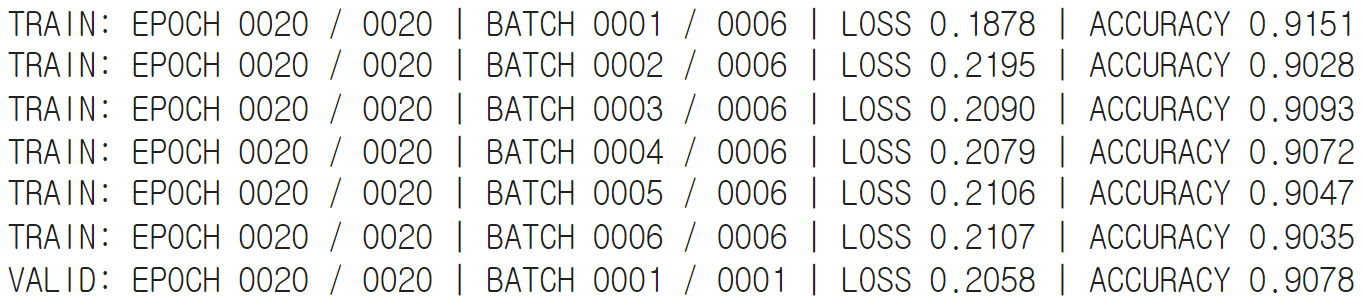

In [12]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)
# 테스트 수행하기
with torch.no_grad():
    net.eval()
    loss_arr = []
    accuracy_arr = []

    for batch, data in enumerate(loader_test, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # 손실 함수 계산하기
        loss = fn_loss(output, label)
        loss_arr.append(loss.item())

        # 정확도 계산하기
        acc = compute_accuracy(output, label)
        accuracy_arr.append(acc)

        print("TEST: BATCH %04d / %04d | LOSS %.4f | ACCURACY %.4f" %
              (batch, num_batch_test, np.mean(loss_arr), np.mean(accuracy_arr)))

        # 결과 저장하기
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        for j in range(label.shape[0]):
            id = num_batch_test * (batch - 1) + j

            plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

            np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

    # 평균 손실과 정확도 출력
    avg_loss = np.mean(loss_arr)
    avg_accuracy = np.mean(accuracy_arr)
    print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f | ACCURACY %.4f" %
          (batch, num_batch_test, avg_loss, avg_accuracy))

TEST: BATCH 0001 / 0001 | LOSS 0.1922 | ACCURACY 0.9178
AVERAGE TEST: BATCH 0001 / 0001 | LOSS 0.1922 | ACCURACY 0.9178


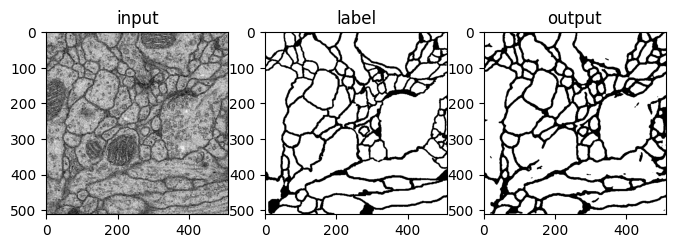

In [13]:
######  결과를 확인해보세요!  ######
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()

### 문제 6.

U-Net의 논문과 코드 모두를 살펴보았습니다. 해당 과제를 수행하면서 알게 된 U-Net의 특징을 1) 모델 설계 의도 2) 구조적 특징 3) 손실함수 및 데이터 증강기법으로 나누어 서술해주세요.

[풀이]

1. U-Net은 세포 등 의학 관련 이미지의 segmentation에 활발히 사용된다. 그렇기 때문에 이미지 구조를 세밀하고 정확히 예측하는 것이 중요하다. 또한, 의학 분야의 특성상 제한된 데이터셋으로도, U-Net은 좋은 성능을 낼 수 있도록 설계되었다는 특징이 있다.

2. U-Net의 구조는 다운샘플링을 통해 특징을 추출하고, 업샘플링을 통해 원래의 해상도를 복원하는 구조로 이루어져 있다. 이 두 과정을 각각 Contracting Path, Expansive Path라고 부른다. 또한, Skip Connection을 통해 세부 정보를 보존하고 더욱 정확한 segmentation을 가능토록 한다.

3. U-Net은 주로 Cross-Entropy Loss or Dice Coefficient Loss를 사용하여 segmentation의 정확성을 평가한다. 데이터 증강기법은 훈련 과정에 적용되어 모델의 일반화 성능을 높일 수 있고, 데이터의 다양성을 증가시킬 수 있다. 위 실습에서는 Flip과 Rotation을 사용하였다.


수고 많으셨습니다 !! 💖

References:\
10기 윤형진 CNN 과제